In [1]:
import os
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sn
from collections import Counter
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras import regularizers

import keras.backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

from IPython.display import Image, HTML
from tensorflow.keras.utils import plot_model

In [2]:

train_dir = '..//train/'
test_dir = '..//test/'



IMAGE_SIZE = (48,48)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

BS = 64
EPOCHS = 100
ADAM_LEARNING_RATE = 0.0001
PATIENCE =10

classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [4]:

train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = IMAGE_SIZE,
                                                   class_mode = 'categorical',
                                                   batch_size = BS)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  shuffle =True,
                                                  batch_size = BS)

Found 28709 images belonging to 7 classes.
Found 7156 images belonging to 7 classes.


In [5]:
# Data labels

class_labels = test_dataset.class_indices
class_labels

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

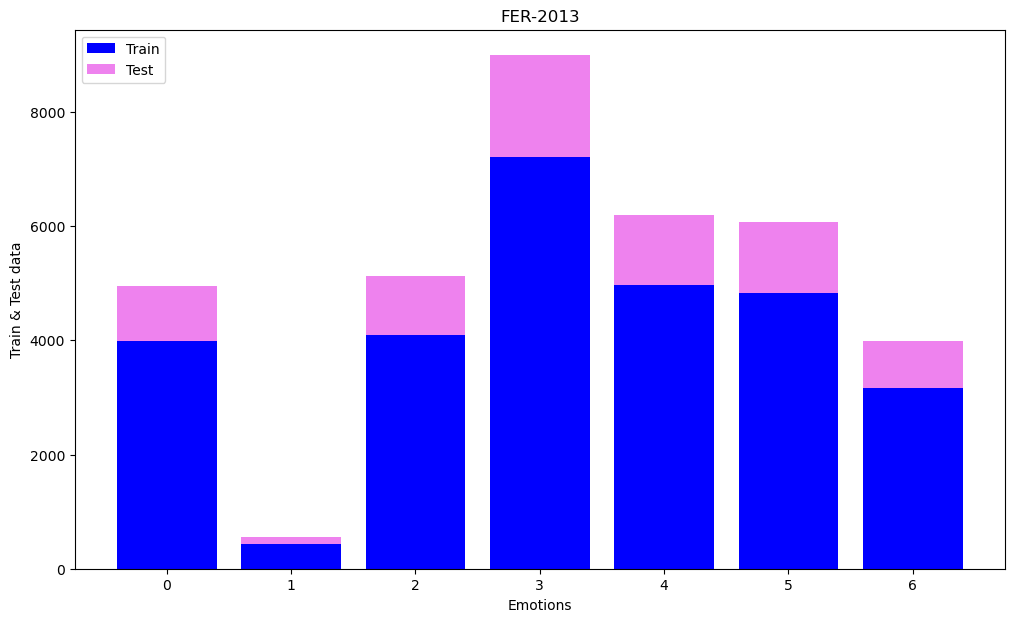

In [6]:
# Calculate class counts for train and test datasets
train_count = Counter(train_dataset.classes)
test_count = Counter(test_dataset.classes)

# Plot distribution of train/test dataset per class
x = list(test_count.keys())
y1 = [train_count[label] for label in x]
y2 = [test_count[label] for label in x]

plt.figure(figsize=(12,7))

plt.bar(x, y1, color='blue')
plt.bar(x, y2, bottom=y1, color='violet')
plt.xlabel("Emotions")
plt.ylabel("Train & Test data")
plt.legend(["Train", "Test"], loc='upper left')
plt.title("FER-2013")
plt.savefig('distribution.png')
plt.show()


In [7]:
# VGG16

base_model = tf.keras.applications.VGG16(input_shape= IMAGE_SHAPE,include_top=False,weights="imagenet")
base_model.summary()



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [8]:
# Freezing Layers

for layer in base_model.layers[:11]:
    layer.trainable=False

In [9]:
# Build transfer learning Model

model=Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GaussianNoise(0.01))
model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 batch_normalization (Batch  (None, 1, 1, 512)         2048      
 Normalization)                                                  
                                                                 
 gaussian_noise (GaussianNo  (None, 1, 1, 512)         0         
 ise)                                                            
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                        

In [16]:
# Model trainable

print("Model trainable",len(model.trainable_variables))

Model trainable 24


In [17]:
from keras.models import load_model

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

adam = tf.keras.optimizers.legacy.Adam(learning_rate=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=METRICS)


In [18]:

counter = Counter(train_dataset.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}  

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = PATIENCE,verbose = 1,factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint('model2.h5', save_best_only=True)
es = EarlyStopping(monitor='val_loss', # Monitors the model's validation loss
                               patience=3, # Number of epochs with no improvement after which training will be stopped
                               verbose=1, # Logs when training is stopped
                               restore_best_weights=True)

history=model.fit(train_dataset,
                  validation_data=test_dataset,
                  epochs = EPOCHS,
                  verbose =1,
                  callbacks = [lrd,mcp,es], 
                  class_weight = class_weights)



Epoch 1/100
 29/449 [>.............................] - ETA: 6:20 - loss: 2.6969 - accuracy: 0.8796 - precision: 0.6714 - recall: 0.3082 - auc: 0.8412 - f1_score: 0.4224

KeyboardInterrupt: 

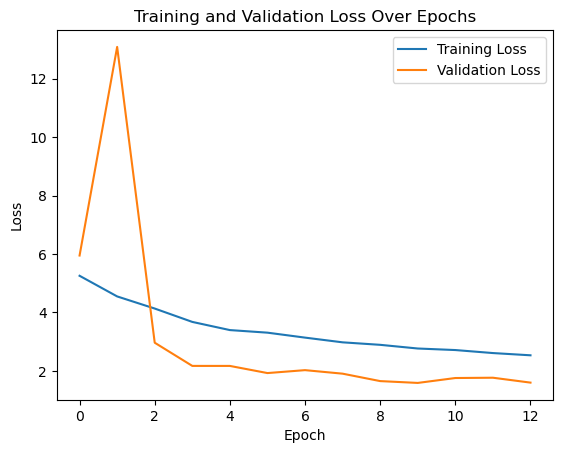

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
#  Som Scores of train & test set

train_evalation = model.evaluate(train_dataset)
test_evaluation = model.evaluate(test_dataset)

112/112 [==============================] - 66s 591ms/step - loss: 1.5893 - accuracy: 0.8894 - precision: 0.7756 - recall: 0.3178 - auc: 0.8758 - f1_score: 0.4481


In [16]:
test_dataset = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    shuffle=False,  # Set to False to maintain the order of predictions
    batch_size=64  # Adjust based on your system's memory
)

predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)

Found 7178 images belonging to 7 classes.
113/113 [==============================] - 50s 441ms/step


In [18]:
from sklearn.metrics import accuracy_score

true_labels = test_dataset.classes

#print(accuracy_score(y_true, y_pred))
cm = tf.math.confusion_matrix(
    true_labels,
    predicted_classes,
    num_classes=len(test_dataset.class_indices)
)

Confusion matrix, without normalization

[[ 490   20  120   46   91  171   20]
 [  21   68    5    2    2   12    1]
 [ 103    8  440   60   86  226  101]
 [  56    1   35 1486   77   72   47]
 [  61    2   97  120  676  244   33]
 [ 110   15  199   88  165  644   26]
 [  17    0  112   36   25   15  626]]




Accuracy: 0.6172

Classification Report:
               precision    recall  f1-score   support

       Angry       0.57      0.51      0.54       958
     Disgust       0.60      0.61      0.60       111
        Fear       0.44      0.43      0.43      1024
       Happy       0.81      0.84      0.82      1774
     Neutral       0.60      0.55      0.57      1233
         Sad       0.47      0.52      0.49      1247
    Surprise       0.73      0.75      0.74       831

    accuracy                           0.62      7178
   macro avg       0.60      0.60      0.60      7178
weighted avg       0.62      0.62      0.62      7178



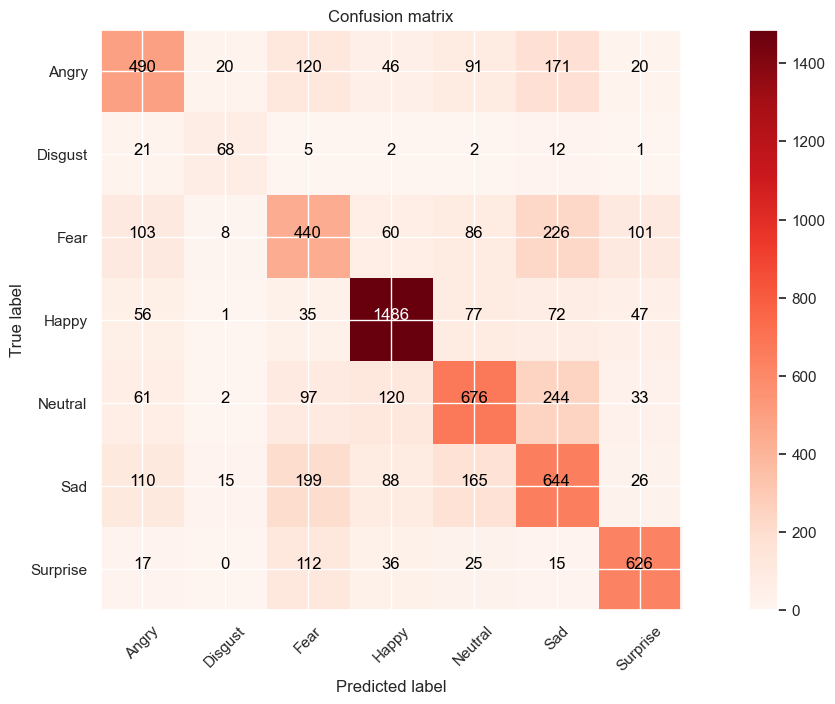

In [24]:
from sklearn.metrics import classification_report, accuracy_score
cm_np = cm.numpy()

plt.rcParams['figure.figsize'] = (14, 7)

# Use seaborn API to set the style
sn.set(style='darkgrid')

plt.imshow(cm_np, interpolation='nearest', cmap='Reds')
plt.title('Confusion matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

print('Confusion matrix, without normalization\n')
print(cm_np)

print("\n\n")

accuracy = accuracy_score(true_labels, predicted_classes)
classification_report_str = classification_report(true_labels, predicted_classes, target_names=classes)

print(f'\nAccuracy: {accuracy:.4f}\n')
print('Classification Report:\n', classification_report_str)


thresh = cm_np.max() / 2.
for i, j in itertools.product(range(cm_np.shape[0]), range(cm_np.shape[1])):
    plt.text(j, i, cm_np[i, j],
             horizontalalignment="center",
             color="white" if cm_np[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model2_final.h5")
